In [1]:
import os
import math
import time

from contextlib import contextmanager
import numpy as np
import pandas as pd
from IPython.display import display
import lightgbm
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [3]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(12, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('../output/lgbm_importances_bayesian.png')

In [4]:
def kfold_lightgbm(df, num_folds, stratified = False, epochs = 1, corr_save = False, importance_save = False):
    df = df.drop('Unnamed: 0', axis = 1)  
    
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    
    # Correlation csv processing
    if corr_save == True:
        target_corr = train_df.corr()['TARGET'].sort_values()
        corr_df = pd.DataFrame()
        corr_df['feature'] = target_corr.index
        corr_df['corr'] = target_corr.values
        corr_df = corr_df[corr_df['feature'] != 'feature']
        corr_df.to_csv('../output/correlation.csv')
        del target_corr, corr_df


    cat_cols = ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FLAG_MOBIL', 'FLAG_EMP_PHONE',
                'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
                'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 
                'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY',
                'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
                'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_11', 
                'FLAG_DOCUMENT_18', 'CODE_GENDER', 'NAME_CONTRACT_TYPE',
                'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'EMERGENCYSTATE_MODE',
                'HOUSETYPE_MODE', 'FONDKAPREMONT_MODE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
                'NAME_HOUSING_TYPE', 'NAME_TYPE_SUITE', 'WALLSMATERIAL_MODE','WEEKDAY_APPR_PROCESS_START',
                'HOUR_APPR_PROCESS_START', 'NAME_INCOME_TYPE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE']
    
    included_cat_cols = [i for i in cat_cols if i in list(train_df.columns)]
    
    # Delete variables from memory 
    del df, cat_cols

    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    # Initialise predictions and importance dataframes and epoch weights
    sub_df = test_df[['SK_ID_CURR']].copy()
    sub_df['TARGET'] = 0
    ep_ave = 1/epochs
    epv_preds = np.zeros(train_df.shape[0])
    feature_importance_df = pd.DataFrame()    
    
    for n in range(epochs):
        
        print('Epoch number {} of {} starting'.format(n+1, epochs))
        # Cross validation model
        if epochs == 1:
            if stratified:
                folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
            else:
                folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
        else:
            if stratified:
                folds = StratifiedKFold(n_splits= num_folds, shuffle=True)
            else:
                folds = KFold(n_splits= num_folds, shuffle=True)
        # Create arrays and dataframes to store results
        oof_preds = np.zeros(train_df.shape[0])
        sub_preds = np.zeros(test_df.shape[0])
        feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]

        for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
            dtrain = lightgbm.Dataset(data=train_df[feats].iloc[train_idx], 
                                 label=train_df['TARGET'].iloc[train_idx], 
                                 free_raw_data=False, silent=True)#,
#                                  categorical_feature=included_cat_cols)
            dvalid = lightgbm.Dataset(data=train_df[feats].iloc[valid_idx], 
                                 label=train_df['TARGET'].iloc[valid_idx], 
                                 free_raw_data=False, silent=True)#,
#                                  categorical_feature=included_cat_cols)

            # LightGBM parameters found by Bayesian optimization
            params = {
                'objective': 'binary',
                'boosting_type': 'gbdt', # 'goss'
                'nthread': 4,
                'learning_rate': 0.02,  # 02,
                'num_leaves': 20,
                'colsample_bytree': 0.9497036,
                'subsample': 0.8715623,
                'subsample_freq': 1,
                'max_depth': 8,
                'reg_alpha': 0.041545473,
                'reg_lambda': 0.0735294,
                'min_split_gain': 0.0222415,
                'min_child_weight': 60, #39.3259775
                'seed': 0,
                'verbose': -1,
                'metric': 'auc',
            }

            clf = lightgbm.train(
                params=params,
                train_set=dtrain,
                num_boost_round=10000,
                valid_sets=[dtrain, dvalid],
                early_stopping_rounds= 200,
                verbose_eval=100
            )

            oof_preds[valid_idx] = clf.predict(dvalid.data)
            sub_preds += clf.predict(test_df[feats]) / folds.n_splits

            fold_importance_df = pd.DataFrame()
            fold_importance_df["feature"] = feats
            fold_importance_df["importance"] = clf.feature_importance(importance_type='gain')
            fold_importance_df["fold"] = n_fold + 1
            feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
            print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(dvalid.label, oof_preds[valid_idx])))
            del clf, dtrain, dvalid
            
        print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
        # Write submission file and plot feature importance
        sub_df['TARGET'] += ep_ave*sub_preds
        epv_preds += ep_ave*oof_preds
        print('Epoch number {} of {} ended'.format(n+1, epochs))
        
    sub_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    print('Full AUC score over all epochs %.6f' % roc_auc_score(train_df['TARGET'], epv_preds))
    display_importances(feature_importance_df)
    
    # Save feature importance df as csv
    if importance_save == True:
        feature_importance_df = feature_importance_df.groupby('feature').agg('mean').drop('fold', axis = 1).sort_values('importance')
        feature_importance_df.to_csv('../output/importance_3.2.csv')

Starting LightGBM. Train shape: (307511, 660), test shape: (48744, 660)
Epoch number 1 of 1 starting
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.765773	valid_1's auc: 0.757919
[200]	training's auc: 0.785837	valid_1's auc: 0.773707
[300]	training's auc: 0.79749	valid_1's auc: 0.781408
[400]	training's auc: 0.806117	valid_1's auc: 0.78584
[500]	training's auc: 0.813117	valid_1's auc: 0.788738
[600]	training's auc: 0.819153	valid_1's auc: 0.790663
[700]	training's auc: 0.824531	valid_1's auc: 0.79199
[800]	training's auc: 0.829365	valid_1's auc: 0.7928
[900]	training's auc: 0.83404	valid_1's auc: 0.793354
[1000]	training's auc: 0.838268	valid_1's auc: 0.79378
[1100]	training's auc: 0.842338	valid_1's auc: 0.794246
[1200]	training's auc: 0.846283	valid_1's auc: 0.794722
[1300]	training's auc: 0.850175	valid_1's auc: 0.794911
[1400]	training's auc: 0.853798	valid_1's auc: 0.795085
[1500]	training's auc: 0.857313	valid_1's auc: 0.795232
[1600]	train

Run LightGBM with kfold - done in 6672s
Full model run - done in 6745s


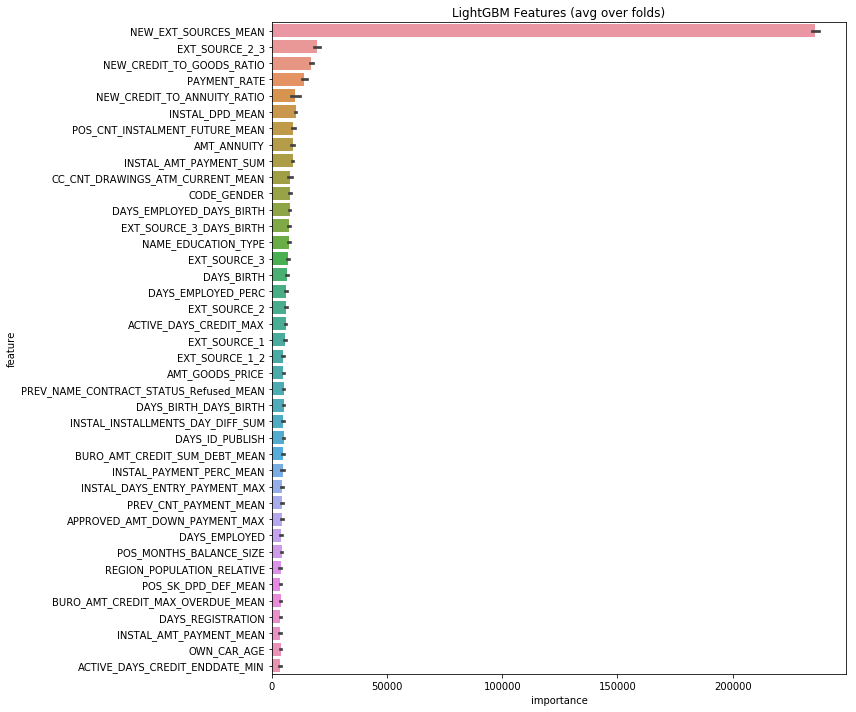

In [5]:
def main():
    
    df = pd.read_csv('../data/processed_data_3.2.csv')
    
    with timer("Run LightGBM with kfold"):
        feature_importance_df = kfold_lightgbm(df,
                                               num_folds=5,
                                               stratified=False,
                                               epochs=1,
                                               corr_save=False,
                                               importance_save=False) 

if __name__ == "__main__":
    submission_file_name = "../predictions/lightgbm_pred_nocat.csv"
    with timer("Full model run"):
        main()